# Chapter13. 使用Theano并行训练神经网络
- 使用Theano编写优化的机器学习代码
- 为人工神经网络选择合适的激励函数
- 使用Keras深度学习库进行快速便捷的实验

## 1. 使用Theano构建、编译并运行表达式
### a. Theano初探

In [1]:
import theano
from theano import tensor as T

In [3]:
# 变量初始化
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# 编译
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# 运行
net_input(2.0, 1.0, 0.5)

array(2.5)

### b. Theano配置

In [4]:
# 浮点变量的默认值
print(theano.config.floatX)

float64


In [5]:
# 修改浮点变量
theano.config.floatX= 'float32'

In [7]:
print(theano.config.floatX)

float32


In [6]:
# 默认运算设备为CPU
print(theano.config.device)

cpu


### c. 使用数组结构
通过tensor使用数组结构

In [8]:
import numpy as np

# 初始化
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# 编译
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# 运行
ary = [[1, 2, 3], [1, 2, 3]]
print('Column sum:', calc_sum(ary))

ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print('Column sum:', calc_sum(ary))

Column sum: [2. 4. 6.]
Column sum: [2. 4. 6.]


Theano的share变量允许我们使用大型对象，这些对象可以被多种类型的函数读写，这样我们就可以在编译后更新这些对象。

In [9]:
x = T.fmatrix(name='x')
w = theano.shared(np.array([[0.0, 0.0, 0.0]],dtype=theano.config.floatX))

z = x.dot(w.T)
update = [[w, w+1.0]]

net_input = theano.function(inputs=[x], updates=update, outputs=z)

data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[0.]]
z1: [[6.]]
z2: [[12.]]
z3: [[18.]]
z4: [[24.]]


In [10]:
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix(name='x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))

z = x.dot(w.T)
update = [[w, w+1.0]]

# compile
net_input = theano.function(inputs=[], 
                            updates=update, 
                            givens={x: data},
                            outputs=z)

# execute
for i in range(5):
    print('z:', net_input())

z: [[0.]]
z: [[6.]]
z: [[12.]]
z: [[18.]]
z: [[24.]]


### d. 线性回归示例

In [11]:
import numpy as np
X_train = np.asarray([[0.0], [1.0], [2.0], [3.0], [4.0],
                      [5.0], [6.0], [7.0], [8.0], [9.0]], 
                     dtype=theano.config.floatX)

y_train = np.asarray([1.0, 1.3, 3.1, 2.0, 5.0, 
                      6.3, 6.6, 7.4, 8.0, 9.0], 
                     dtype=theano.config.floatX)

在构造numpy数组时，我们将数据设定为`theano.config.floatX`，这使得我们可以在需要的时候将数据在CPU和GPU之间来回传递

In [14]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):

    costs = []
    # Initialize arrays
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y') 
    X = T.fmatrix(name='X')   
    w = theano.shared(np.zeros(
                      shape=(X_train.shape[1] + 1),
                      dtype=theano.config.floatX),
                      name='w')
    
    # calculate cost
    net_input = T.dot(X, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2)) 

    # perform gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]

    # compile model
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={X: X_train,
                                    y: y_train})      
    
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

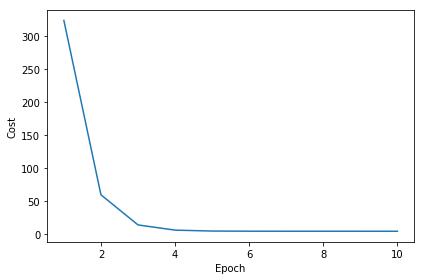

In [15]:
import matplotlib.pyplot as plt

costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
   
plt.plot(range(1, len(costs)+1), costs)

plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()

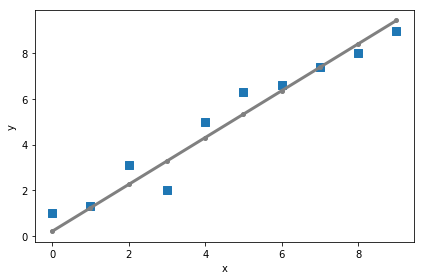

In [17]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    return predict(X)

plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), 
         predict_linreg(X_train, w), 
         color='gray', 
         marker='o', 
         markersize=4, 
         linewidth=3)

plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

## 2. 为前馈神经网络选择激励函数
### a. sigmoid函数

In [18]:
X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


In [19]:
# W : array, shape = [n_output_units, n_hidden_units+1]
#          Weight matrix for hidden layer -> output layer.
# note that first column (W[:][0]) contains the bias units
W = np.array([[1.1, 1.2, 1.3, 0.5],
              [0.1, 0.2, 0.4, 0.1],
              [0.2, 0.5, 2.1, 1.9]])

# A : array, shape = [n_hidden+1, n_samples]
#          Activation of hidden layer.
# note that first element (A[0][0] = 1) is for the bias units

A = np.array([[1.0], 
              [0.1], 
              [0.3], 
              [0.7]])

# Z : array, shape = [n_output_units, n_samples]
#          Net input of output layer.

Z = W.dot(A) 
y_probas = logistic(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[0.87653295]
 [0.57688526]
 [0.90114393]]


In [20]:
y_class = np.argmax(Z, axis=0)
print('predicted class label: %d' % y_class[0])

predicted class label: 2


### b. softmax函数
softmax是更一般的Sigmoid函数，在多类别分类中，它使得我们能够计算所有类别隶属的概率。

$$P(y=j|z) =\phi_{softmax}(z) = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$

In [21]:
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

In [22]:
y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [[0.40386493]
 [0.07756222]
 [0.51857284]]


In [23]:
y_probas.sum()

1.0

In [24]:
y_class = np.argmax(Z, axis=0)
y_class

array([2])

### c. 双曲正切函数
$$\phi_{tanh}(z) = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}$$

Output range: (-1, 1)

In [25]:
def tanh(z):
    e_p = np.exp(z) 
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)  

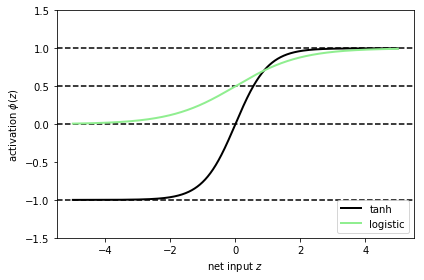

In [26]:
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

# alternatives:
# from scipy.special import expit
# log_act = expit(z)
# tanh_act = np.tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')

plt.plot(z, tanh_act, 
         linewidth=2, 
         color='black', 
         label='tanh')
plt.plot(z, log_act, 
         linewidth=2, 
         color='lightgreen', 
         label='logistic')

plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/activation.png', dpi=300)
plt.show()

## 3. 使用Keras提高训练神经网络的效率
加载MNIST数据集

In [1]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

In [2]:
X_train, y_train = load_mnist('../datasets/MNIST/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


In [3]:
X_test, y_test = load_mnist('../datasets/MNIST/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


In [4]:
import theano 

theano.config.floatX = 'float32'
X_train = X_train.astype(theano.config.floatX)
X_test = X_test.astype(theano.config.floatX)

独热编码

In [5]:
from keras.utils import np_utils

print('First 3 labels: ', y_train[:3])

y_train_ohe = np_utils.to_categorical(y_train) 
print('\nFirst 3 labels (one-hot):\n', y_train_ohe[:3])

Using TensorFlow backend.


First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [12]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

np.random.seed(1)

# 使用Sequential初始化一个模型来实现前馈神经网络
model = Sequential()
# 加入输入层，input_dim为本层的单元数量
# units为本层输出的数量，也就是下一层的输入
model.add(Dense(input_dim=X_train.shape[1],
                units=50,
                kernel_initializer='uniform',
                activation='tanh'))

model.add(Dense(input_dim=50,
                units=50,
                kernel_initializer='uniform',
                activation='tanh'))

model.add(Dense(input_dim=50,
                units=y_train_ohe.shape[1],
                kernel_initializer='uniform',
                activation='softmax'))

# 定义优化器，使用梯度下降进行优化
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy',   # 交叉熵，和逻辑回归的代价函数相关
              optimizer=sgd, 
              metrics=['accuracy'])

model.fit(X_train, y_train_ohe, 
          epochs=50, 
          batch_size=300, 
          verbose=1, 
          validation_split=0.1) 

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 1s 21us/step - loss: 2.2207 - acc: 0.4285 - val_loss: 2.0861 - val_acc: 0.6240
Epoch 2/50
54000/54000 [==============================] - 1s 16us/step - loss: 1.8300 - acc: 0.6188 - val_loss: 1.5086 - val_acc: 0.6595
Epoch 3/50
54000/54000 [==============================] - 1s 16us/step - loss: 1.3003 - acc: 0.6599 - val_loss: 1.0789 - val_acc: 0.7342
Epoch 4/50
54000/54000 [==============================] - 1s 16us/step - loss: 0.9802 - acc: 0.7478 - val_loss: 0.8156 - val_acc: 0.8068
Epoch 5/50
54000/54000 [==============================] - 1s 17us/step - loss: 0.7771 - acc: 0.8113 - val_loss: 0.6550 - val_acc: 0.8558
Epoch 6/50
54000/54000 [==============================] - 1s 17us/step - loss: 0.6448 - acc: 0.8509 - val_loss: 0.5444 - val_acc: 0.8798
Epoch 7/50
54000/54000 [==============================] - 1s 17us/step - loss: 0.5561 - acc: 0.8683 - val_loss: 0.4703 - val_acc:

In [13]:
y_train_pred = model.predict_classes(X_train, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

train_acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (train_acc * 100))

y_test_pred = model.predict_classes(X_test, verbose=0)
test_acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

First 3 predictions:  [5 0 4]
Training accuracy: 94.42%
Test accuracy: 93.63%
